In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from rc_buildingsimulator.building_physics import Zone  # Importing Zone Class
from rc_buildingsimulator import supply_system
from rc_buildingsimulator import emission_system
from rc_buildingsimulator.radiation import Location
from rc_buildingsimulator.radiation import Window

matplotlib.style.use('ggplot')

In [2]:
# Empty Lists for Storing Data to Plot
ElectricityOut = []
HeatingDemand = []  # Energy required by the zone
HeatingEnergy = []  # Energy required by the supply system to provide HeatingDemand
CoolingDemand = []  # Energy surplus of the zone
CoolingEnergy = []  # Energy required by the supply system to get rid of CoolingDemand
IndoorAir = []
OutsideTemp = []
SolarGains = []
COP = []

In [3]:
# Initialise the Location with a weather file
Zurich = Location(epwfile_path='../rc_buildingsimulator/auxiliary/Zurich-Kloten_2013.epw')

In [4]:
# Initialise an instance of the Zone. Empty spaces take on the default
# parameters. See ZonePhysics.py to see the default values
Office = Zone(window_area=4.0,
              walls_area=11.0,
              floor_area=35.0,
              room_vol=105,
              total_internal_area=142.0,
              lighting_load=11.7,
              lighting_control=300.0,
              lighting_utilisation_factor=0.45,
              lighting_maintenance_factor=0.9,
              u_walls=0.2,
              u_windows=1.1,
              ach_vent=1.5,
              ach_infl=0.5,
              ventilation_efficiency=0.6,
              thermal_capacitance_per_floor_area=165000,
              t_set_heating=20.0,
              t_set_cooling=26.0,
              max_cooling_energy_per_floor_area=-np.inf,
              max_heating_energy_per_floor_area=np.inf,
              heating_supply_system=supply_system.OilBoilerMed,
              cooling_supply_system=supply_system.HeatPumpAir,
              heating_emission_system=emission_system.NewRadiators,
              cooling_emission_system=emission_system.AirConditioning,)

In [5]:
# Define Windows
SouthWindow = Window(azimuth_tilt=0, alititude_tilt=90, glass_solar_transmittance=0.7,
                     glass_light_transmittance=0.8, area=4)

In [6]:
# A catch statement to prevent future coding bugs when modifying window area
if SouthWindow.area != Office.window_area:
    raise ValueError('Window area defined in radiation file doesnt match area defined in zone')

In [7]:
# Define constants for the Zone
gain_per_person = 100  # W per person
appliance_gains = 14  # W per sqm
max_occupancy = 3.0

In [8]:
# Read Occupancy Profile
occupancyProfile = pd.read_csv('../rc_buildingsimulator/auxiliary/schedules_el_OFFICE.csv')

In [9]:
# Starting temperature of the builidng
t_m_prev = 20

In [10]:
# Loop through all 8760 hours of the year
for hour in range(8760):

    # Occupancy for the time step
    occupancy = occupancyProfile.loc[hour, 'People'] * max_occupancy
    
    # Gains from occupancy and appliances
    internal_gains = occupancy * gain_per_person + \
        appliance_gains * Office.floor_area

    # Extract the outdoor temperature in Zurich for that hour
    t_out = Zurich.weather_data['drybulb_C'][hour]

    Altitude, Azimuth = Zurich.calc_sun_position(
        latitude_deg=47.480, longitude_deg=8.536, year=2015, hoy=hour)

    SouthWindow.calc_solar_gains(sun_altitude=Altitude, sun_azimuth=Azimuth,
                                 normal_direct_radiation=Zurich.weather_data[
                                     'dirnorrad_Whm2'][hour],
                                 horizontal_diffuse_radiation=Zurich.weather_data['difhorrad_Whm2'][hour])

    SouthWindow.calc_illuminance(sun_altitude=Altitude, sun_azimuth=Azimuth,
                                 normal_direct_illuminance=Zurich.weather_data[
                                     'dirnorillum_lux'][hour],
                                 horizontal_diffuse_illuminance=Zurich.weather_data['difhorillum_lux'][hour])

    Office.solve_energy(internal_gains=internal_gains,
                        solar_gains=SouthWindow.solar_gains,
                        t_out=t_out,
                        t_m_prev=t_m_prev)

    Office.solve_lighting(
        illuminance=SouthWindow.transmitted_illuminance, occupancy=occupancy)

    # Set the previous temperature for the next time step
    t_m_prev = Office.t_m_next

    HeatingDemand.append(Office.heating_demand)
    HeatingEnergy.append(Office.heating_energy)
    CoolingDemand.append(Office.cooling_demand)
    CoolingEnergy.append(Office.cooling_energy)
    ElectricityOut.append(Office.electricity_out)
    IndoorAir.append(Office.t_air)
    OutsideTemp.append(t_out)
    SolarGains.append(SouthWindow.solar_gains)
    COP.append(Office.cop)

In [11]:
annualResults = pd.DataFrame({
    'HeatingDemand': HeatingDemand,
    'HeatingEnergy': HeatingEnergy,
    'CoolingDemand': CoolingDemand,
    'CoolingEnergy': CoolingEnergy,
    'IndoorAir': IndoorAir,
    'OutsideTemp':  OutsideTemp,
    'SolarGains': SolarGains,
    'COP': COP
})

<AxesSubplot:>

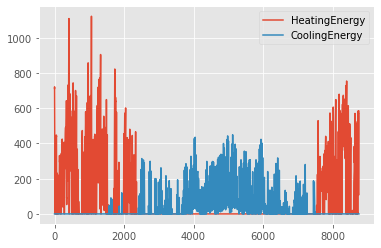

In [12]:
# Plotting has been commented out as it can not be conducted in a virtual environment over ssh
annualResults[['HeatingEnergy', 'CoolingEnergy']].plot()